# Imports

In [1]:
#!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
### INSTALLATION OF PACKAGES ###
!pip install torch
#!pip install torch-scatter 
#!pip install torch-sparse 
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install networkx
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=9cf9a7563bd1c4248c44cdef7f5352d25420cce89ca1c2fe477b30eac177e2fc
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch_geometric


In [2]:
### IMPORTS ###
import os
import time
import random
import numpy as np
import networkx as nx
from math import ceil

from scipy.stats import ortho_group

import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential


from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.utils.convert import to_networkx, from_networkx
import torch_geometric
from torch_geometric.data import Data, Batch
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse, get_laplacian
from torch_geometric.loader import DataLoader, GraphSAINTRandomWalkSampler, DenseDataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, GCNConv, DenseSAGEConv, DenseSAGEConv, dense_diff_pool, GraphConv, TopKPooling
from torch_geometric.datasets import Planetoid, GNNBenchmarkDataset, LRGBDataset


from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import SAGEConv
#from torch_scatter import scatter
#from torch_sparse import SparseTensor

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from google.colab import files
from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.0.0+cu118
PyG version 2.3.0


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#Loading Dataset

In [4]:
# Transforms functions (for dense rep)

class filter(object):
    def __call__(self, data):
        return data.num_nodes <= max_nodes

## Loading ENZYME dataset ##
max_nodes = 200
ENZYMES = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
ENZYMES_Dense = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', transform=T.ToDense(max_nodes),pre_filter=filter())

## Loading Peptides-func
PEPTIDES = LRGBDataset(root = 'tmp/Peptides-func', name = 'Peptides-func')

## Loading CLUSTER dataset ##
max_nodes = 1000
CLUSTER = GNNBenchmarkDataset(root = 'tmp/CLUSTER', name = 'CLUSTER')[:1000]
CLUSTER_Dense = GNNBenchmarkDataset(root = 'tmp/CLUSTER', name = 'CLUSTER', transform=T.ToDense(max_nodes),pre_filter=filter())

## Loading PROTEINS dataset ##
PROTEINS = TUDataset(root = 'tmp/PROTEINS', name = 'PROTEINS')
PROTEINS_Dense = TUDataset(root = 'tmp/PROTEINS', name='PROTEINS', transform=T.ToDense(max_nodes),pre_filter=filter())

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/dataset.py:217: UserWarning: The `pre_filter` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-fitering technique, make sure to delete '{self.processed_dir}' first
  warnings.warn(
Extracting tmp/Peptides-func/peptidesfunc.zip
Processing...
Processing test dataset: 100%|██████████| 2331/2331 [00:00<00:00, 9481.97it/s] 
Done!
Extracting tmp/CLUSTER/CLUSTER/raw/CLUSTER_v2.zip
Processing...
Done!
Extracting tmp/PROTEINS/PROTEINS/PROTEINS.zip
Processing...
Done!


## Pre-processing Data

In [7]:
# Pre-processing functions
def one_hot_encoder(data, num_classes, size):
  ## Function to 1-hot encode a 1-d Array such as data.y in PyG
  matrix = np.zeros((size, num_classes))
  for value in range(size):
    matrix[value][data[value]] = 1
  return matrix


def train_test_split(dataset, percent_train):
  split_indices = np.random.choice(len(dataset), size=int(percent_train * len(dataset)), replace=False)
  # train split
  train = dataset[split_indices]
  # test split
  test = dataset[~np.isin(np.arange(len(dataset)), split_indices)]
  return train, test



## Splitting datasets
ENZYMES_classes = ENZYMES.num_classes
ENZYMES_node_features = ENZYMES.num_features

train_dataset, test_dataset = train_test_split(ENZYMES,0.8)
train_loader_ENZYMES = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_ENZYMES = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataset_dense, test_dataset_dense = train_test_split(ENZYMES_Dense,0.8)
train_loader_ENZYMES_Dense = DenseDataLoader(train_dataset_dense, batch_size=32, shuffle=True)
test_loader_ENZYMES_Dense = DenseDataLoader(test_dataset_dense, batch_size=32, shuffle=False)

## -- 

PEPTIDES_classes = PEPTIDES.num_classes
PEPTIDES_node_features = PEPTIDES.num_features


train_dataset_peptides, test_dataset_peptides = train_test_split(PEPTIDES[:2000],0.8)
train_loader_PEPTIDES = DataLoader(train_dataset_peptides, batch_size=32, shuffle=True)
test_loader_PEPTIDES = DataLoader(test_dataset_peptides, batch_size=32, shuffle=False)

## --


CLUSTER_classes = CLUSTER.num_classes
CLUSTER_node_features = CLUSTER.num_features

train_dataset_CLUSTER, test_dataset_CLUSTER = train_test_split(CLUSTER,0.8)
train_loader_CLUSTER = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_CLUSTER = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataset_CLUSTER_Dense, test_dataset_CLUSTER_Dense = train_test_split(CLUSTER_Dense,0.8)
train_loader_CLUSTER_Dense = DenseDataLoader(train_dataset_CLUSTER_Dense, batch_size=32, shuffle=True)
test_loader_CLUSTER_Dense = DenseDataLoader(test_dataset_CLUSTER_Dense, batch_size=32, shuffle=False)



PROTEINS_classes = PROTEINS.num_classes
PROTEINS_node_features = PROTEINS.num_features

train_dataset_PROTEINS, test_dataset_PROTEINS = train_test_split(ENZYMES,0.8)
train_loader_PROTEINS = DataLoader(train_dataset_PROTEINS[:1000], batch_size=32, shuffle=True)
test_loader_PROTEINS = DataLoader(test_dataset_PROTEINS[:250], batch_size=32, shuffle=False)

train_dataset_PROTEINS_dense, test_dataset_PROTEINS_dense = train_test_split(PROTEINS_Dense,0.8)
train_loader_ENZYMES_PROTEINS_Dense = DenseDataLoader(train_dataset_PROTEINS_dense, batch_size=32, shuffle=True)
test_loader_ENZYMES_PROTEINS_Dense = DenseDataLoader(test_dataset_PROTEINS_dense, batch_size=32, shuffle=False)




#Regular  GCN
We will use simple 3-layer GCN and GraphSAINT 

In [6]:
class GraphConvClassifier(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_p = 0):
    super(GraphConvClassifier, self).__init__()

    self.dropout_rate = dropout_p

    self.layers = nn.ModuleList(
        [GCNConv(input_dim, hidden_dim)]+
        [GCNConv(hidden_dim, hidden_dim) for i in range(num_layers -1)]+
        [nn.Linear(hidden_dim, output_dim)]
    )

  def forward(self, x, edge_index, batch):
    for layer in self.layers[:-1]:
      x = layer(x , edge_index)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout_rate)
    x = global_mean_pool(x, batch)
    x = self.layers[-1](x)
    return F.softmax(x, dim=1)


class GraphConvClassifierBinary(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_p = 0):
    super(GraphConvClassifierBinary, self).__init__()

    self.dropout_rate = dropout_p

    self.layers = nn.ModuleList(
        [GCNConv(input_dim, hidden_dim)]+
        [GCNConv(hidden_dim, hidden_dim) for i in range(num_layers -1)]+
        [nn.Linear(hidden_dim, output_dim)]
    )

  def forward(self, x, edge_index, batch):
    for layer in self.layers[:-1]:
      x = layer(x , edge_index)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout_rate)
    x = global_mean_pool(x, batch)
    x = self.layers[-1](x)
    return F.sigmoid(x)



In [7]:
def train_graph_classification(model, train_loader, test_loader, num_epochs, lr = 0.01):
    # Set up the loss and the optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= lr)
    Test_acc = []
    # A utility function to compute the accuracy
    def get_acc(model, loader):
        model.eval()
        n_total = 0.000000001 #Avoid division by Zero
        num_identical = 0
        for data in loader:
            data = data.to(device)
            outs = model(data.x.float(), data.edge_index, data.batch).squeeze()
            test_class = np.argmax(outs.detach().cpu().numpy(), axis=1)
            outs = test_class.tolist()  
            num_identical += np.sum(outs == data.y.detach().cpu().numpy())
            n_total += data.y.shape[0]
        return num_identical/n_total



    for epoch in range(num_epochs):        
        for data in train_loader:
            # Zero grads -> forward pass -> compute loss -> backprop
            data = data.to(device)
            optimizer.zero_grad()
            outs = model(data.x.float(), data.edge_index, data.batch).squeeze()
            test_class = torch.argmax(outs, dim=1).float()
            loss = loss_fn(outs.float(), data.y) 
            loss.backward()
            optimizer.step()

        # Compute accuracies
        acc_train = get_acc(model, train_loader)
        acc_test = get_acc(model, test_loader)
        Test_acc.append(acc_test)
        #print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss} | Train: {acc_train:.3f} | Test: {acc_test:.3f}')
    return Test_acc


def train_graph_classification_binary(model, train_loader, test_loader, num_epochs, lr = 0.01):
    # Set up the loss and the optimizer
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= lr)
    Test_acc = []
    # A utility function to compute the accuracy
    def get_acc(model, loader):
        model.eval()
        n_total = 0.000000001 #Avoid division by Zero
        num_identical = 0
        for data in loader:
            data = data.to(device)
            outs = model(data.x.float(), data.edge_index, data.batch).squeeze()
            outs = torch.round(outs,decimals=0)
            #test_class = np.argmax(outs.detach().numpy(), axis=1)
            #outs = test_class.tolist()  
            num_identical += np.sum(outs.detach().cpu().numpy() == data.y[:,4].detach().cpu().numpy())
            n_total += data.y.shape[0]
        return num_identical/n_total



    for epoch in range(num_epochs):        
        for data in train_loader:
            # Zero grads -> forward pass -> compute loss -> backprop
            data = data.to(device)
            optimizer.zero_grad()
            outs = model(data.x.float(), data.edge_index, data.batch).squeeze()
            #test_class = torch.argmax(outs, dim=1).float()
            loss = loss_fn(outs.float(), data.y[:,4]) 
            loss.backward()
            optimizer.step()

        # Compute accuracies
        acc_train = get_acc(model, train_loader)
        acc_test = get_acc(model, test_loader)
        Test_acc.append(acc_test)
        #print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss} | Train: {acc_train:.3f} | Test: {acc_test:.3f}')
    return Test_acc

## Enzymes

In [8]:
#Enzymes
model = GraphConvClassifier(input_dim = ENZYMES_node_features, hidden_dim = 64, output_dim = ENZYMES_classes, num_layers = 3).to(device)

tic = time.time()
results_GCN = train_graph_classification(model,train_loader_ENZYMES, test_loader_ENZYMES, 250, 0.001)
toc = time.time()

print('Training took: ', toc-tic)


Training took:  48.13341975212097


## Peptides

In [24]:
## Peptides
model = GraphConvClassifierBinary(input_dim = PEPTIDES_node_features, hidden_dim = 64, output_dim = 1, num_layers = 3).to(device)

tic = time.time()
results_GCN_peptides = train_graph_classification_binary(model,train_loader_PEPTIDES, test_loader_PEPTIDES, 100, 0.001)
toc = time.time()

print('Training took: ', toc-tic)


Training took:  72.59014320373535


# TopKPooling

In [10]:
class Top_K_Pooling_Graph_Classifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.95):
        super().__init__()

        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.pool1 = TopKPooling(hidden_dim, ratio=dropout)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.pool2 = TopKPooling(hidden_dim, ratio=dropout)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.pool3 = TopKPooling(hidden_dim, ratio=dropout)

        self.lin1 = torch.nn.Linear(2*hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 32)
        self.lin3 = torch.nn.Linear(32, output_dim)

    #def forward(self, data):
    def forward(self, x, edge_index, batch):
        #x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x



class Top_K_Pooling_Graph_Classifier_Binary(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.95):
        super().__init__()

        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.pool1 = TopKPooling(hidden_dim, ratio=dropout)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.pool2 = TopKPooling(hidden_dim, ratio=dropout)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.pool3 = TopKPooling(hidden_dim, ratio=dropout)

        self.lin1 = torch.nn.Linear(2*hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 32)
        self.lin3 = torch.nn.Linear(32, output_dim)

    #def forward(self, data):
    def forward(self, x, edge_index, batch):
        #x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.sigmoid(self.lin3(x))

        return x

In [14]:
model = Top_K_Pooling_Graph_Classifier(input_dim = ENZYMES_node_features, hidden_dim = 64, output_dim = ENZYMES_classes).to(device)

tic = time.time()

results_topk = train_graph_classification(model,train_loader_ENZYMES, test_loader_ENZYMES, 250, 0.001 )
toc = time.time()

print('Training took: ', toc-tic)


/usr/local/lib/python3.9/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Training took:  121.28983283042908


In [25]:
model = Top_K_Pooling_Graph_Classifier_Binary(input_dim = PEPTIDES_node_features, hidden_dim = 64, output_dim = 1).to(device)

tic = time.time()
results_topk_peptides = train_graph_classification_binary(model,train_loader_PEPTIDES, test_loader_PEPTIDES, 100, 0.001)
toc = time.time()

print('Training took: ', toc-tic)


/usr/local/lib/python3.9/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Training took:  182.06895184516907


#Graph Group Renormalization

In [24]:
sum_nodes = 0
count = 0
for graph in test_dataset:
  sum_nodes += graph.x.shape[0]
  count +=1
print('Average Node count in ENZYMES Test Dataset before coarsening:', sum_nodes/count)

sum_nodes = 0
count = 0
for graph in train_dataset:
  sum_nodes += graph.x.shape[0]
  count +=1
print('Average Node count in ENZYMES Train Dataset before coarsening:', sum_nodes/count)

sum_nodes = 0
count = 0
for graph in test_dataset:
  sum_nodes += graph.edge_index.shape[1]
  count +=1
print('Average Edge count in ENZYMES Test Dataset before coarsening:', sum_nodes/count)

sum_nodes = 0
count = 0
for graph in train_dataset:
  sum_nodes += graph.edge_index.shape[1]
  count +=1
print('Average Edge count in ENZYMES Train Dataset before coarsening:', sum_nodes/count)

##
sum_nodes = 0
count = 0
for graph in test_dataset_peptides:
  sum_nodes += graph.x.shape[0]
  count +=1
print('Average Node count in Peptides Test Dataset before coarsening:', sum_nodes/count)

sum_nodes = 0
count = 0
for graph in train_dataset_peptides:
  sum_nodes += graph.x.shape[0]
  count +=1
print('Average Node count in Peptides Train Dataset before coarsening:', sum_nodes/count)

sum_nodes = 0
count = 0
for graph in test_dataset_peptides:
  sum_nodes += graph.edge_index.shape[1]
  count +=1
print('Average edge count in Peptides Test Dataset before coarsening:', sum_nodes/count)

sum_nodes = 0
count = 0
for graph in train_dataset_peptides:
  sum_nodes += graph.edge_index.shape[1]
  count +=1
print('Average edge count in Peptides Train Dataset before coarsening:', sum_nodes/count)

Average Node count in ENZYMES Test Dataset before coarsening: 31.091666666666665
Average Node count in ENZYMES Train Dataset before coarsening: 33.01875
Average Edge count in ENZYMES Test Dataset before coarsening: 121.33333333333333
Average Edge count in ENZYMES Train Dataset before coarsening: 125.00833333333334
Average Node count in Peptides Test Dataset before coarsening: 148.28
Average Node count in Peptides Train Dataset before coarsening: 151.67375
Average edge count in Peptides Test Dataset before coarsening: 301.84
Average edge count in Peptides Train Dataset before coarsening: 308.89375


In [5]:
def aggregate_feats_nx(u_attr, v_attr, aggr_style = 'mean'):
  '''
  Helper function for node contraction. It supports mean by default
  '''
  if aggr_style == 'mean':
    concat = np.concatenate((u_attr, v_attr), axis=0)
    concat = np.reshape(concat, (2, int(len(concat)/2)))
    mean = np.mean(concat, axis = 0)
    return mean

  if aggr_style == 'maxpool':
    concat = np.concatenate((u_attr, v_attr), axis=0)
    concat = np.reshape(concat, (2, int(len(concat)/2)))
    max_pool = np.amax(concat, axis=0)
    return max_pool

  if aggr_style =='delete':
    return u_attr

def Laplacian_coarse_graining(G, aggr = 'mean'):
  '''
  Input: a PyG data Object (a graph)
  Output: Coarse-Grained PyG data Object

  Content - the function will apply laplacian coarse graining on the graph
  '''
  y = G.y
  #Convert PyG Data Object to NetworkX
  nx_graph = to_networkx(G,node_attrs=["x"], to_undirected = True)

  #obtain Laplacian
  L = nx.laplacian_matrix(nx_graph).todense()
  L = np.array(L)
  G = nx_graph
  # Getting the pseudo-inverse of the Laplacian
  C = np.linalg.pinv(L)

  
  correlated_nodes = []
  correlations = []
  #Find pair of connected nodes
  for i in range(len(C)):
    for j in range(i):
        correlated_nodes.append([i,j])
        correlations.append(C[i,j])
    
  # Sorting the nodes descending correlation
  most_correlated_nodes = []
  x = np.array(correlations).argsort()
  correlated_nodes_sorted = np.array(correlated_nodes)[x[::-1]]
  used_nodes_lst = []
  for i in range(len(x)): # Most correlated nodes
    corr_pair = [int(j) for j in correlated_nodes_sorted[i]]
    no_duplicates = corr_pair not in most_correlated_nodes
    both_nodes_unused = all(x not in used_nodes_lst for x in corr_pair)

    if both_nodes_unused and no_duplicates:
        most_correlated_nodes.append(corr_pair)
        used_nodes_lst.extend(corr_pair)


  #Re-wire the graph by contracting highly-correlated edges
  for pair in most_correlated_nodes:
    [u, v] = pair
    ### Note - when contracting nodes, an additional attribute will be added called "contraction". We need to get rid of it.
    u_attributes = G.nodes[u]['x']
    v_attributes = G.nodes[v]['x']
    G = nx.contracted_nodes(G, u, v)
    attributes = {u: {'x': list(aggregate_feats_nx(u_attributes, v_attributes, aggr))}} 
    nx.set_node_attributes(G, attributes)
    del G.nodes[u]['contraction']
  #Deleting all edge features created under the process of contraction
  for (n1, n2, d) in G.edges(data=True):
    d.clear()
  
  #Converting back to PyG Data Object
  try:
    to_return = from_networkx(G, group_node_attrs = 'x')
    to_return.y = y
  except:
    print('Could not convert NetworkX object to PyG Data Object')
  
  return to_return

In [8]:
## idea: create a new list of obj
##Applying Coarsening on Datasets

tic = time.time()

train_coarse_dataset = []
test_coarse_dataset = []
count =0
for graph in train_dataset:
  train_coarse_dataset.append(Laplacian_coarse_graining(graph))
  count +=1

for graph in test_dataset:
  test_coarse_dataset.append(Laplacian_coarse_graining(graph))
  count +=1
toc = time.time()
print('Time Processing Enzymes - mean: ', toc-tic, ' Seconds')
print('Coarsening Enzymes done')

tic = time.time()

train_coarse_dataset_max = []
test_coarse_dataset_max = []
count =0
for graph in train_dataset:
  train_coarse_dataset_max.append(Laplacian_coarse_graining(graph, 'maxpool'))
  count +=1

for graph in test_dataset:
  test_coarse_dataset_max.append(Laplacian_coarse_graining(graph, 'maxpool'))
  count +=1
toc = time.time()
print('Time Processing Enzymes - maxpool: ', toc-tic, ' Seconds')
print('Coarsening Enzymes done')



tic = time.time()

train_coarse_dataset_delete = []
test_coarse_dataset_delete = []
count =0
for graph in train_dataset:
  train_coarse_dataset_delete.append(Laplacian_coarse_graining(graph, 'delete'))

for graph in test_dataset:
  test_coarse_dataset_delete.append(Laplacian_coarse_graining(graph, 'delete'))
toc = time.time()
print('Time Processing Enzymes - deletion: ', toc-tic, ' Seconds')
print('Coarsening Enzymes done')


################# PEPTIDES ##################

tic = time.time()

train_coarse_dataset_peptides = []
test_coarse_dataset_peptides = []
count =0
for graph in train_dataset_peptides:
  train_coarse_dataset_peptides.append(Laplacian_coarse_graining(graph))
  count +=1

for graph in test_dataset_peptides:
  test_coarse_dataset_peptides.append(Laplacian_coarse_graining(graph))
  count +=1
toc = time.time()
print('Time Processing Peptides - mean: ', toc-tic, ' Seconds')

tic = time.time()

train_coarse_dataset_max_peptides = []
test_coarse_dataset_max_peptides = []
count =0
for graph in train_dataset_peptides:
  train_coarse_dataset_max_peptides.append(Laplacian_coarse_graining(graph, 'maxpool'))
  count +=1
  if count % 500 ==0:
    print(count)

for graph in test_dataset_peptides:
  test_coarse_dataset_max_peptides.append(Laplacian_coarse_graining(graph, 'maxpool'))
  count +=1
toc = time.time()
print('Time Processing Peptides - maxpool: ', toc-tic, ' Seconds')



tic = time.time()

train_coarse_dataset_delete_peptides = []
test_coarse_dataset_delete_peptides = []
count =0
for graph in train_dataset_peptides:
  train_coarse_dataset_delete_peptides.append(Laplacian_coarse_graining(graph, 'delete'))
  count +=1

for graph in test_dataset_peptides:
  test_coarse_dataset_delete_peptides.append(Laplacian_coarse_graining(graph, 'delete'))
  count +=1
toc = time.time()
print('Time Processing Peptides - delete: ', toc-tic, ' Seconds')
print('Coarsening Peptides done')


Time Processing Enzymes - mean:  8.739818572998047  Seconds
Coarsening Enzymes done
Time Processing Enzymes - maxpool:  13.264192342758179  Seconds
Coarsening Enzymes done
Time Processing Enzymes - deletion:  10.142611742019653  Seconds
Coarsening Enzymes done
Time Processing Peptides - mean:  489.05284094810486  Seconds
500
1000
1500
Time Processing Peptides - maxpool:  462.9696190357208  Seconds
Time Processing Peptides - delete:  450.3893325328827  Seconds
Coarsening Peptides done


In [25]:
## compute new average graph length!!
sum_nodes = 0
count = 0
for graph in test_coarse_dataset:
  sum_nodes += graph.x.shape[0]
  count +=1
print('Average Node count in ENZYMES Test Dataset before coarsening:', sum_nodes/count)

sum_nodes = 0
count = 0
for graph in train_coarse_dataset:
  sum_nodes += graph.x.shape[0]
  count +=1
print('Average Node count in ENZYMES Train Dataset before coarsening:', sum_nodes/count)


sum_nodes = 0
count = 0
for graph in test_coarse_dataset:
  sum_nodes += graph.edge_index.shape[1]
  count +=1
print('Average Edge count in ENZYMES Test Dataset before coarsening:', sum_nodes/count)

sum_nodes = 0
count = 0
for graph in train_coarse_dataset:
  sum_nodes += graph.edge_index.shape[1]
  count +=1
print('Average Edge count in ENZYMES Train Dataset before coarsening:', sum_nodes/count)


##

sum_nodes = 0
count = 0
for graph in test_coarse_dataset_delete_peptides:
  sum_nodes += graph.x.shape[0]
  count +=1
print('Average Node count in Peptides Test Dataset after coarsening:', sum_nodes/count)

sum_nodes = 0
count = 0
for graph in train_coarse_dataset_delete_peptides:
  sum_nodes += graph.x.shape[0]
  count +=1
print('Average Node count in Peptides Train Dataset after coarsening:', sum_nodes/count)


sum_nodes = 0
count = 0
for graph in test_coarse_dataset_peptides:
  sum_nodes += graph.edge_index.shape[1]
  count +=1
print('Average edge count in Peptides Test Dataset after coarsening:', sum_nodes/count)

sum_nodes = 0
count = 0
for graph in train_coarse_dataset_peptides:
  sum_nodes += graph.edge_index.shape[1]
  count +=1
print('Average edge count in Peptides Train Dataset after coarsening:', sum_nodes/count)

Average Node count in ENZYMES Test Dataset before coarsening: 15.733333333333333
Average Node count in ENZYMES Train Dataset before coarsening: 16.70625
Average Edge count in ENZYMES Test Dataset before coarsening: 61.3
Average Edge count in ENZYMES Train Dataset before coarsening: 64.6125
Average Node count in Peptides Test Dataset after coarsening: 74.3825
Average Node count in Peptides Train Dataset after coarsening: 76.074375
Average edge count in Peptides Test Dataset after coarsening: 220.05
Average edge count in Peptides Train Dataset after coarsening: 225.435625


In [17]:
train_loader = DataLoader(train_coarse_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_coarse_dataset, batch_size=32, shuffle=False)

model = GraphConvClassifier(input_dim = ENZYMES_node_features, hidden_dim = 64, output_dim = ENZYMES_classes, num_layers = 3).to(device)
tic = time.time()
result_mean = train_graph_classification(model,train_loader, test_loader, 250, lr = 0.001)
toc = time.time()
print('training for mean aggregation took', toc-tic)



train_loader = DataLoader(train_coarse_dataset_max, batch_size=32, shuffle=True)
test_loader = DataLoader(test_coarse_dataset_max, batch_size=32, shuffle=False)
tic = time.time()
result_maxpool = train_graph_classification(model,train_loader, test_loader, 250, lr = 0.001)
toc = time.time()
print('training for max-pool aggregation took', toc-tic)


train_loader = DataLoader(train_coarse_dataset_delete, batch_size=32, shuffle=True)
test_loader = DataLoader(test_coarse_dataset_delete, batch_size=32, shuffle=False)
tic = time.time()
result_delete = train_graph_classification(model,train_loader, test_loader, 250, lr = 0.001)
toc = time.time()
print('training for deletion aggregation took', toc-tic)


training for mean aggregation took 42.442052125930786
training for max-pool aggregation took 44.05279064178467
training for deletion aggregation took 41.71221899986267


In [23]:
## Peptides:
train_loader = DataLoader(train_coarse_dataset_peptides, batch_size=32, shuffle=True)
test_loader = DataLoader(test_coarse_dataset_peptides, batch_size=32, shuffle=False)

model = GraphConvClassifierBinary(input_dim = PEPTIDES_node_features, hidden_dim = 64, output_dim = 1, num_layers = 3).to(device)
tic = time.time()
result_mean_peptides = train_graph_classification_binary(model,train_loader, test_loader, 100, lr = 0.001)
toc = time.time()
print('training for mean aggregation took', toc-tic)



train_loader = DataLoader(train_coarse_dataset_max_peptides, batch_size=32, shuffle=True)
test_loader = DataLoader(test_coarse_dataset_max_peptides, batch_size=32, shuffle=False)
tic = time.time()
result_maxpool_peptides = train_graph_classification_binary(model,train_loader, test_loader, 100, lr = 0.001)
toc = time.time()
print('training for max-pool aggregation took', toc-tic)


train_loader = DataLoader(train_coarse_dataset_delete_peptides, batch_size=32, shuffle=True)
test_loader = DataLoader(test_coarse_dataset_delete_peptides, batch_size=32, shuffle=False)
tic = time.time()
result_delete_peptides = train_graph_classification_binary(model,train_loader, test_loader, 100, lr = 0.001)
toc = time.time()
print('training for deletion aggregation took', toc-tic)


training for mean aggregation took 61.96637415885925
training for max-pool aggregation took 60.74643278121948
training for deletion aggregation took 60.66118001937866


#Plots

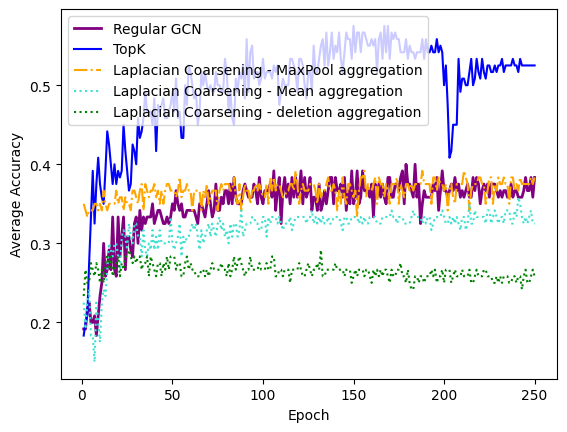

In [36]:
## Plot 1: Convergence 


labels = np.arange(1, 251, 1, dtype=int)

fig, ax = plt.subplots()


ax.plot(labels, results_GCN, color='purple', label='Regular GCN', linestyle='-', linewidth = 2)
ax.plot(labels, results_topk, color='blue', label='TopK', linestyle='-')
ax.plot(labels, result_maxpool, color='orange', label='Laplacian Coarsening - MaxPool aggregation', linestyle = '-.')
ax.plot(labels, result_mean, color='turquoise', label='Laplacian Coarsening - Mean aggregation', linestyle = 'dotted')
ax.plot(labels, result_delete, color='green', label='Laplacian Coarsening - deletion aggregation', linestyle = 'dotted')

ax.set_xlabel('Epoch')
ax.set_ylabel('Average Accuracy')
ax.legend()
plt.show()


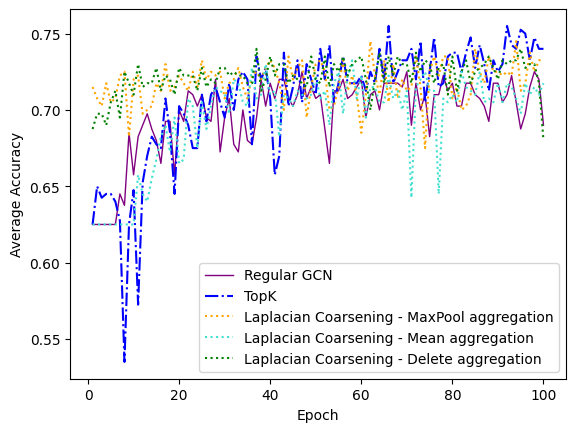

In [35]:
## Plot 2: Convergence 


labels = np.arange(1, 101, 1, dtype=int)

fig, ax = plt.subplots()


ax.plot(labels, results_GCN_peptides, color='purple', label='Regular GCN', linestyle='-', linewidth = 1)
ax.plot(labels, results_topk_peptides, color='blue', label='TopK', linestyle='-.')
ax.plot(labels, result_maxpool_peptides, color='orange', label='Laplacian Coarsening - MaxPool aggregation', linestyle = 'dotted')
ax.plot(labels, result_mean_peptides, color='turquoise', label='Laplacian Coarsening - Mean aggregation', linestyle = 'dotted')
ax.plot(labels, result_delete_peptides, color='green', label='Laplacian Coarsening - Delete aggregation', linestyle = 'dotted')

ax.set_xlabel('Epoch')
ax.set_ylabel('Average Accuracy')
ax.legend()
plt.show()

# Please disregard the content below




landeau model Hamiltonian
page 458 : https://www.academia.edu/30081175/Huang_Kerson_1987_Statistical_Mechanics_2Ed_Wiley_T_506S_pdf


#DiffPool
Stadard Implementation as per the https://www.youtube.com/watch?v=Uqc3O3-oXxM Tutorial with more details here
https://github.com/d-stoll/diffpool. 

Some adaptations were made to the code

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 normalize=False, lin=True):
        super().__init__()

        self.conv1 = DenseSAGEConv(in_channels, hidden_channels, normalize)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = DenseSAGEConv(hidden_channels, hidden_channels, normalize)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = DenseSAGEConv(hidden_channels, out_channels, normalize)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)

        if lin is True:
            self.lin = torch.nn.Linear(2 * hidden_channels + out_channels,
                                       out_channels)
        else:
            self.lin = None

    def bn(self, i, x):
        print(x.size())
        batch_size, num_nodes, num_channels = x.size()

        x = x.view(-1, num_channels)
        x = getattr(self, f'bn{i}')(x)
        x = x.view(batch_size, num_nodes, num_channels)
        return x

    def forward(self, x, adj, mask=None):
         
        batch_size, num_nodes, in_channels = x.size()

        x0 = x
        x1 = self.bn(1, self.conv1(x0, adj, mask).relu())
        x2 = self.bn(2, self.conv2(x1, adj, mask).relu())
        x3 = self.bn(3, self.conv3(x2, adj, mask).relu())

        x = torch.cat([x1, x2, x3], dim=-1)

        if self.lin is not None:
            x = self.lin(x).relu()

        return x


class DiffPool_Graph_Classifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_features, dropout = 0.8, max_nodes=100):
        super().__init__()
        num_nodes = ceil(0.25 * max_nodes)


        self.gnn1_pool = GNN(input_dim, 64, num_nodes)
        self.gnn1_embed = GNN(num_features, 64, hidden_dim, lin=False)

        num_nodes = ceil(0.25 * num_nodes)
        self.gnn2_pool = GNN(3 * hidden_dim, 64, num_nodes)
        self.gnn2_embed = GNN(3 * hidden_dim, 64, hidden_dim, lin=False)

        self.gnn3_embed = GNN(3 * hidden_dim, 64, hidden_dim, lin=False)

        self.lin1 = torch.nn.Linear(3 * hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, adj, mask=None):
        s = self.gnn1_pool(x, adj, mask)
        x = self.gnn1_embed(x, adj, mask)

        x, adj, l1, e1 = dense_diff_pool(x, adj, s, mask)

        s = self.gnn2_pool(x, adj)
        x = self.gnn2_embed(x, adj)

        x, adj, l2, e2 = dense_diff_pool(x, adj, s)

        x = self.gnn3_embed(x, adj)

        x = x.mean(dim=1)
        x = self.lin1(x).relu()
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1), l1 + l2, e1 + e2




In [ ]:
def train(epoch):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


model = DiffPool_Graph_Classifier(input_dim = ENZYMES_node_features, hidden_dim = 64, output_dim = ENZYMES_classes, num_features = ENZYMES_node_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


train_graph_classification(model,train_loader_ENZYMES_Dense, test_loader_ENZYMES_Dense, 100, 0.015 )


AttributeError: ignored

In [ ]:

test = DiffPool(ENZYMES_node_features, ENZYMES_classes)

print(train_dataset[0])

test(train_dataset[0].x, train_dataset[0].edge_index)



Data(edge_index=[2, 84], x=[21, 3], y=[1])


ValueError: ignored

#GraphSAINT

Disregard

In [ ]:
loader = GraphSAINTRandomWalkSampler(dataset[0], batch_size=600, walk_length=2,
                                     num_steps=5, sample_coverage=100,
                                     save_dir=dataset.processed_dir,
                                     num_workers=4)



/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Compute GraphSAINT normalization: 100%|██████████| 3700/3700 [00:03<00:00, 1016.79it/s]


In [ ]:
## Delete??

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(hidden_channels=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    model.set_aggr('add' if args.use_normalization else 'mean')

    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()

        if args.use_normalization:
            edge_weight = data.edge_norm * data.edge_weight
            out = model(data.x, data.edge_index, edge_weight)
            loss = F.nll_loss(out, data.y, reduction='none')
            loss = (loss * data.node_norm)[data.train_mask].sum()
        else:
            out = model(data.x, data.edge_index)
            loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_nodes
        total_examples += data.num_nodes
    return total_loss / total_examples

NameError: ignored

# GraphSAGE
Disregard

In [ ]:
## Defining GraphSAGE structure
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_p = 0 ):
        super(GraphSAGE, self).__init__()

        self.conv_layers = nn.ModuleList(
          [SAGEConv(input_dim, hidden_dim)] + 
          [SAGEConv(hidden_dim, hidden_dim ) for i in range(num_layers - 1)] +
          [nn.Linear(hidden_dim,output_dim)]
          )
        self.p = dropout_p

    def forward(self, x, edge_index, batch):
      for layer in self.conv_layers[:-1]:

        x = layer(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.p)
      x = torch_geometric.nn.global_mean_pool(x, batch)
      x = self.conv_layers[-1](x)
      return F.softmax(x, dim=1)

model = GraphSAGE(1,64,1,4)
print(model)

GraphSAGE(
  (conv_layers): ModuleList(
    (0): SAGEConv(1, 64, aggr=mean)
    (1-3): 3 x SAGEConv(64, 64, aggr=mean)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


# Training